In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

Connect Google Drive.  This is done so that the models and data reading can be standard across the different testing environments and any changes will be universal.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Weather')

from seq_to_seq import MultiHeadModel, LSTM_Model
from process import df_to_np_seq

Mounted at /content/drive


df_to_np is a helper functions to convert csv to training data format

x = last (context_window) readings

y = next reading

If there is a blank or invalid value, that entry is skipped.  This can lead to (context_window) readings that are not (context_window) consecutive hours but are (context_window) entries

In [ ]:
def remove_blanks(df):
  '''Removes all rows with invalids in the df'''
  df = df.replace('', np.nan)
  df = df.dropna() # drops rows with NaN

  return df

Read in the data

In [ ]:
context_window = 48

In [ ]:
df_train = pd.read_csv('/content/processed_data/train.csv')
df_train = df_train.set_index(['USAF ID',
                               'Observation Year',
                               'Observation Month',
                               'Observation Day',
                               'Observation Hour'])

df_test = pd.read_csv('/content/processed_data/test.csv')
df_test = df_test.set_index(['USAF ID',
                             'Observation Year',
                             'Observation Month',
                             'Observation Day',
                             'Observation Hour'])

start_year, end_year = 2010, 2024
USAFs_train = ['720553', '744860', '725030', '725020', '725053']
USAFs_test = ['744864']

df_train = remove_blanks(df_train)
df_test = remove_blanks(df_test)

x_train, y_train, _ = df_to_np_seq(df_train, USAFs_train, start_year, end_year, context_window, overlap=True)
x_test, y_test, test_hi_lows = df_to_np_seq(df_test, USAFs_test, start_year, end_year, context_window, overlap=True)

print(f'{len(x_train)} training samples')
print(f'{len(x_test)} testing samples')


1/5
2/5
3/5
4/5
5/5
1/1
429585 training samples
119779 testing samples


Normalize the data before training

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

timesteps = len(x_train[0])
features = len(x_train[0][0])

x_train_reshaped = x_train.reshape(len(x_train) * timesteps, -1)
x_test_reshaped = x_test.reshape(len(x_test) * timesteps, -1)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

x_train = x_train_scaled.reshape(len(x_train), timesteps, features)
x_test = x_test_scaled.reshape(len(x_test), timesteps, features)

# targets
y_train_reshape = y_train.reshape(len(x_train) * timesteps, -1)
y_test_reshape = y_test.reshape(len(x_test) * timesteps, -1)

y_train_scaled = scaler.transform(y_train_reshape)
y_test_scaled = scaler.transform(y_test_reshape)

y_train = y_train_scaled.reshape(len(x_train), timesteps, features)
y_test = y_test_scaled.reshape(len(x_test), timesteps, features)


Shuffle order

In [ ]:
indices = np.random.permutation(len(x_train))

x_train = x_train[indices]
y_train = y_train[indices]

Build Validation Set

In [ ]:
valid_split = int(len(x_train) * 0.05)

x_valid = x_train[:valid_split]
y_valid = y_train[:valid_split]

x_train = x_train[valid_split:]
y_train = y_train[valid_split:]

Build the model

In [ ]:
from tensorflow.keras.layers import Input, MultiHeadAttention, Add, LayerNormalization, Dense

seq_len = context_window  # Length of time series
d_model = 7  # Single entry dimension
num_heads = 8  # Number of attention heads
# out_seq_len = out_window # Number of series to predict
batch_size = 4

Multihead Attention Approach

In [ ]:
model = MultiHeadModel(seq_len, d_model, num_heads)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 mha1 (MultiHeadAttention)   (None, 48, 7)                1743      ['input[0][0]',               
                                                                     'input[0][0]',               
                                                                     'input[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'mha1[0][0]']            

LSTM Approach

In [ ]:
model = LSTM_Model(seq_len, d_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 lstm1 (LSTM)                (None, 48, 14)               1232      ['input[0][0]']               
                                                                                                  
 dense (Dense)               (None, 48, 7)                105       ['lstm1[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'dense[0][0]']         

Create sequence to sequence loss


In [ ]:
def custom_seq_prediction_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.math.reduce_mean(mse)

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
model.compile(loss=custom_seq_prediction_loss, optimizer=opt)

In [ ]:
# Train the model and store model parameters/loss values
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=[x_valid, y_valid], callbacks=[reduce_lr])#, shuffle=True)

Epoch 1/10
102027/102027 [==============================] - 917s 9ms/step - loss: 0.2562 - val_loss: 0.2404 - lr: 0.0010
Epoch 2/10
102027/102027 [==============================] - 915s 9ms/step - loss: 0.2395 - val_loss: 0.2360 - lr: 0.0010
Epoch 3/10
102027/102027 [==============================] - 910s 9ms/step - loss: 0.2403 - val_loss: 0.2301 - lr: 0.0010
Epoch 4/10
102027/102027 [==============================] - 910s 9ms/step - loss: 0.2414 - val_loss: 0.2350 - lr: 0.0010
Epoch 5/10
102027/102027 [==============================] - 918s 9ms/step - loss: 0.2406 - val_loss: 0.2253 - lr: 0.0010
Epoch 6/10
102027/102027 [==============================] - 916s 9ms/step - loss: 0.2360 - val_loss: 0.2276 - lr: 0.0010
Epoch 7/10
102027/102027 [==============================] - 928s 9ms/step - loss: 0.2326 - val_loss: 0.2159 - lr: 0.0010
Epoch 8/10
102027/102027 [==============================] - 944s 9ms/step - loss: 0.2291 - val_loss: 0.2189 - lr: 0.0010
Epoch 9/10
102027/102027 [======

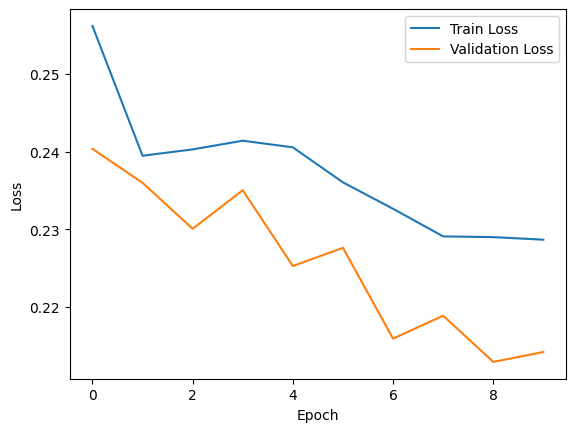

In [ ]:
# Plot the loss curve
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [ ]:
x_test = np.array(x_test)
y_test = np.array(y_test)
model.evaluate(x_test, y_test, batch_size=batch_size)

29945/29945 [==============================] - 118s 4ms/step - loss: 0.1575


0.1575070023536682

Evalutate on the baseline target which is the next 24hr High and Low temps

In [ ]:
def n_next_steps(input, model, n, context_window):
    '''Takes an autoregressive model and returns the n next predictions'''
    out = np.zeros((input.shape[0], n, d_model))
    for i in range(n):
        print(f'{i+1}/{n}\r', end='', flush=True)
        next = model.predict(input, verbose=0)
        out[:, i] = scaler.inverse_transform(next[:, -1, :])
        input = np.roll(input, -1, axis=1)
        input[:, -1] = next[:, -1, :]

    return out


In [ ]:
pred_hi_lows = np.zeros((len(x_test), 2))
pred = n_next_steps(x_test, model, 24, context_window)
hi = np.max(pred[:, :, 0], axis=1)
low = np.min(pred[:, :, 0], axis=1)

pred_hi_lows[:, 0] = hi
pred_hi_lows[:, 1] = low

loss = tf.keras.losses.mean_squared_error(test_hi_lows, pred_hi_lows)
loss = np.mean(loss)
print(loss)

Show n actual samples

In [ ]:
num_samples = 10
for i in range(num_samples):
  print(f'Prediction:   {pred_hi_lows[i]} \nGround Truth: {test_hi_lows[i]} \n')

In [ ]:
num_samples = 10
X = model.predict(np.array(x_test[:num_samples]))
for i in range(num_samples):
  x_out = scaler.inverse_transform([X[i][-1]])
  y_out = scaler.inverse_transform([y_test[i][-1]])
  print(f'Prediction:   {x_out} \nGround Truth: {y_out} \n')

